# Obtain

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel("https://github.com/theleadio/datascience_demo/blob/master/social-ads-raw.xlsx?raw=true")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   segment    200 non-null    int64  
 1   google     200 non-null    float64
 2   facebook   200 non-null    float64
 3   instagram  200 non-null    float64
 4   sales      200 non-null    float64
 5   size       200 non-null    object 
 6   area       200 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 11.1+ KB


# Scrub

In [2]:
print(df.sample(3))
print(df['size'].unique())
print(df['area'].unique())

    segment  google  facebook  instagram  sales   size   area
29       30    70.6      16.0       40.8   10.5  small  urban
51       52   100.4       9.6        3.6   10.7  small  urban
99      100   135.2      41.7       45.9   17.2  small  rural
['large' 'small']
['rural' 'urban' 'suburban']


In [3]:
# convert 'size' & 'area' column to numerical

# we want to know, does large or small size AND rural or urban or sub that makes money better ? (which has lower mrktng_cost/sales_qty ?, or official term which has lower CAC (cust aquisation cost)?)

# but for this to be valid, both 'large' & 'small' must have relatively distributed equally to all features, otherwise this method makes no sense, as whichever has least ones (count < 5) can be seen as outlier
# 6 sets to combine all size & area

lar_r_c = 0
lar_u_c = 0
lar_s_c = 0

sml_r_c = 0
sml_u_c = 0
sml_s_c = 0


df['size_area'] = df['size'] + "_" + df['area']


for i in df['size_area']:

    if i == 'large_rural':
        lar_r_c += 1
    elif i == 'large_urban':
        lar_u_c += 1
    elif i == 'large_suburban':
        lar_s_c += 1

    if i == 'small_rural':
        sml_r_c += 1
    elif i == 'small_urban':
        sml_u_c += 1
    elif i == 'small_suburban':
        sml_s_c += 1

      

print(f"count large rural is {lar_r_c}")
print(f"count large urban is {lar_u_c}")
print(f"count large suburban is {lar_s_c}")
print(f"count small rural is {sml_r_c}")
print(f"count small urban is {sml_u_c}")
print(f"count small suburban is {sml_s_c}")
print(lar_r_c + lar_u_c + lar_s_c + sml_r_c + sml_u_c + sml_s_c == len(df))
print(len(df))

# both has more than 30 samples (in fact both are well-balanced, hence we can do this)


count large rural is 39
count large urban is 29
count large suburban is 40
count small rural is 20
count small urban is 34
count small suburban is 38
True
200


In [4]:
# calculate CAC & set it as new variable
df['cac'] = (df['google'] + df['facebook'] + df['instagram']) / df['sales']

# get mean of cac for small & large
cac_by_sizearea = df.groupby(['size_area']).cac.mean().reset_index()
cac_by_sizearea.sort_values('cac', ascending=False)

,size_area,cac
0,large_rural,14.851971
1,large_suburban,14.296148
4,small_suburban,14.081935
5,small_urban,13.840835
2,large_urban,13.696372
3,small_rural,12.499247


In [5]:
# assign their weight, lower cac will get higher weight

weights = {
    'large_rural' : 1,
    'large_suburban' : 2,
    'small_suburban' : 3,
    'small_urban' : 4,
    'large_urban' : 5,
    'small_rural' : 6
}

df['size_area'] = df['size_area'].apply(lambda x: weights.get(x))
df.sample(3)

,segment,google,facebook,instagram,sales,size,area,size_area,cac
150,151,280.7,13.9,37.0,16.1,large,urban,5,20.596273
122,123,224.0,2.4,15.6,11.6,small,suburban,3,20.862069
37,38,74.7,49.4,45.7,14.7,small,suburban,3,11.551020


In [6]:
# since we created 'size_area' column, we can just drop 'size' & 'area' feature

# but best just put more feature in anyway, as our model will spits outs the useless features anyway
print(df.groupby(['size']).cac.mean())
print(df.groupby(['area']).cac.mean())


size
large    14.335811
small    13.648770
Name: cac, dtype: float64
area
rural       14.054437
suburban    14.191788
urban       13.774336
Name: cac, dtype: float64


In [7]:
# assign weights. lower cac the higher weight

# size 
weights_size = {
    'large' : 1,
    'small' : 2
}

df['size'] = df['size'].apply(lambda x: weights_size.get(x))

# area
weights_area = {
    'suburban' : 1,
    'rural' : 2,
    'urban' : 3
}

df['area'] = df['area'].apply(lambda x: weights_area.get(x))

df.sample(3)

,segment,google,facebook,instagram,sales,size,area,size_area,cac
13,14,97.5,7.6,7.2,9.7,2,3,4,11.577320
99,100,135.2,41.7,45.9,17.2,2,2,6,12.953488
14,15,204.1,32.9,46.0,19.0,2,3,4,14.894737


mini conclusion : 

by individual :
- small sizes with urban area can get more sales out of this mrktng effort

combined :
- company should consider opening new branches in small_rural area

# Explore

<AxesSubplot:ylabel='sales'>

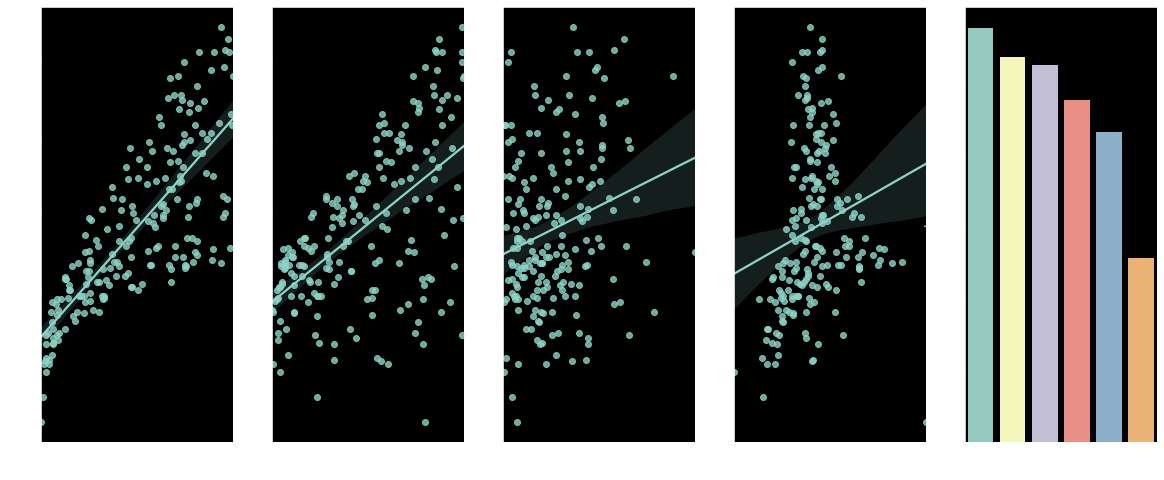

In [8]:
# regplot & countplot to see each features relationship to targetVariable (sales)

fig, subs = plt.subplots(1,5, figsize = (20, 8))

sns.regplot(data=df, x='google', y='sales', ax=subs[0])
sns.regplot(data=df, x='facebook', y='sales', ax=subs[1])
sns.regplot(data=df, x='instagram', y='sales', ax=subs[2])
sns.regplot(data=df, x='cac', y='sales', ax=subs[3])
sns.barplot(x=[1,2,3,4,5,6], y=df.groupby('size_area').sales.sum(), ax=subs[4])     # 'large_rural' : 1, 'large_suburban' : 2, 'small_suburban' : 3, 'small_urban' : 4, 'large_urban' : 5, 'small_rural' : 6

- google & fb has almost linear relationship with sales

# Model
- model1 : linear regression
- model2 : decisionTree regression

In [20]:
# load packages
from sklearn.model_selection import train_test_split

# create feature & target variable
features = ['google', 'facebook', 'instagram', 'size', 'area', 'size_area', 'cac']
X = df[features]
y = df['sales']

In [21]:
# model1 : linearRegression

# import model package
from sklearn.linear_model import LinearRegression

# split to train & test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

# train model
model = LinearRegression()
model = model.fit(X_train, y_train)

# get model accuracy using test data (LinearRegression has build-in accuracy calculation)
acc_score = model.score(X_test, y_test) 

print(f"Model Accuracy on TEST data is {(acc_score * 100):.2f}")

Model Accuracy on TEST data is 96.70


In [22]:
# model2 : decisiontree regression

# import model package
from sklearn import tree

# split to train & test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

# train model
model2 = tree.DecisionTreeRegressor(max_depth=5, random_state=69)

model2 = model2.fit(X_train, y_train)

# get model accuracy using test data (LinearRegression has build-in accuracy calculation)
acc_score = model2.score(X_test, y_test) 

print(f"Model Accuracy on TEST data is {(acc_score * 100):.2f}")


Model Accuracy on TEST data is 95.66


# iNterpret

In [39]:
# model1 : linearRegression

features = ['google', 'facebook', 'instagram', 'size', 'area', 'size_area', 'cac']

print(f"R-squared : {model.score(X_test,y_test):.2f}")
print(f"Intercept : {model.intercept_:.2f}")
print(f"Coefficient : {model.coef_}")
print("    ")
print("In English : ")
print("- In a case if we see that one of the coefficient is actually negative (say, instagram), it only shown mathematically by the historical data that using instagram marketing is actually ineffective, we can see from the RegPlot that there are some case that instagram does bring in sales, just not that much yet, hence we should still allocate some budget, but not as much. reminder that not all past performance does reflect the future performance")
print(f"- We are able to sell {model.intercept_:.2f} units of products if we dont use any marketing promotions (AKA our organic sales)")
print(f"- Assuming other variable stays constant, For every $1000 spent on these marketing methods, it will bring us : \
\n       google : {(model.coef_[0] * 1000):.2f} units of product sold \
\n       fb : {(model.coef_[1] * 1000):.2f} units of product sold \
\n       instagram : {(model.coef_[2] * 1000):.2f} units of product sold")
print("    ")
print(f"From our analysis, if we allocate our marketing spending $27k on goog, $59k in fb, $14k on ig, towards small rural area, we can expect that we will be selling {(model.predict([[27, 59, 14, 2, 2, 6, 13]])[0] * 1000):.2f} units. ")     # simple ratio distribution on goog fb ig, cac is roundUp of size_area we take, which is small_rural

R-squared : 0.97
Intercept : 7.82
Coefficient : [ 0.06072839  0.13019679  0.03880875  0.22526982  0.23209149 -0.09720602
 -0.52802944]
    
In English : 
In a case if we see that one of the coefficient is actually negative (say, instagram), it only shown mathematically by the historical data that using instagram marketing is actually ineffective, we can see from the RegPlot that there are some case that instagram does bring in sales, just not that much yet, hence we should still allocate some budget, but not as much. reminder that not all past performance does reflect the future performance
- We are able to sell 7.82 units of products if we dont use any marketing promotions (AKA our organic sales)
- Assuming other variable stays constant, For every $1000 spent on these marketing methods, it will bring us : 
       google : 60.73 units of product sold 
       fb : 130.20 units of product sold 
       instagram : 38.81 units of product sold
    
From our analysis, if we allocate our mark

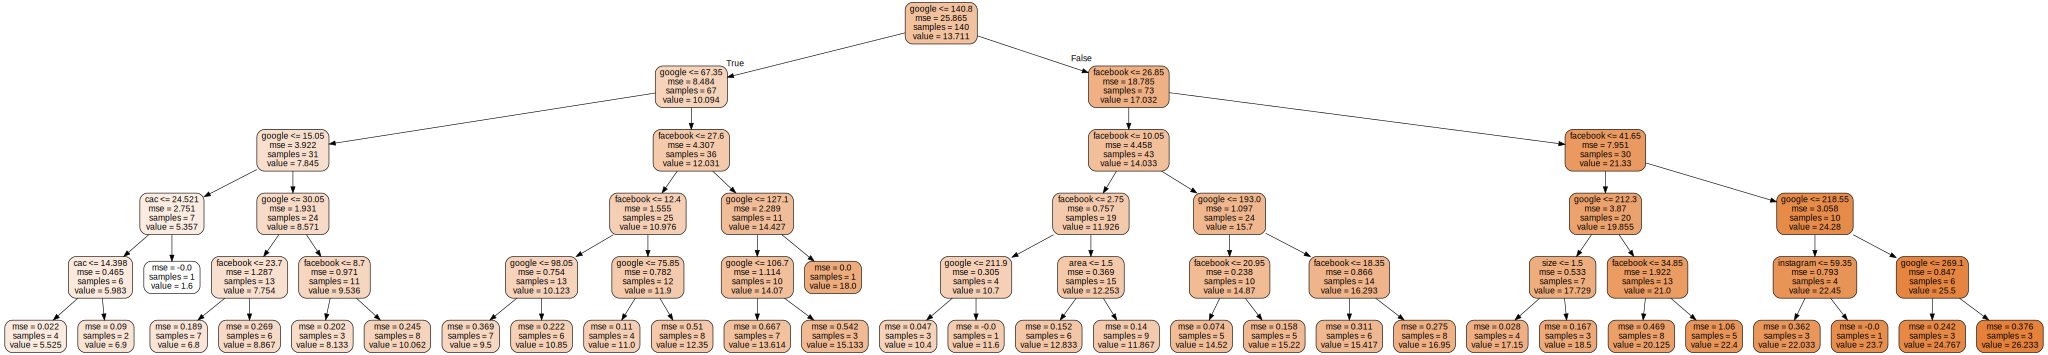

In [196]:
# model2 : decisionTreeRegression

import graphviz

columns = list(X.columns)
dot_data = tree.export_graphviz(model2, out_file=None, feature_names=columns, class_names=['No', 'Yes'], filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

- mse : mean-square-error. lower the value, the more accurate the prediction. (<1 is pretty accurate)
- we can see that if we spent google_ads > $269.1 AND fb_ads > $41.65, we can expect that we can sell 26.233 units (most right root)

questions :

- see scrub data on size_area convert to numerical, is this correct way & does my reasoning makes sense that i do that ? (show screenshot)
- in real world practice, once we see that most of our features have non-linear relationship with targetvalue, wouldnt it make sense if we immediately shift to model that able to capture non-linearity well ? (randomforestregression, or decisiontree ?)
    - test out, and linear vs decisionTree, linear win. any way i can explore on how this happen ? expecting decision win as we can see that most feature are non-linear (94.27% with no max_depth, but 95.80% with max_depth=5 ??)
    - ways to check whether linear or decisionTree arent overfitting ?

- looking at these two models, seems that linearRegression can be interpreted way easier.can you share us a business scenario that decisionTreeRegression will be more favorable & easier to interpret ?, because if there isnt, then whats the point of learning decisionTreee, since its easier to interpret & execute on businessplan & in real-life context